##  Check first on Checkability and Checkworthiness

To Check on Checkability, the first workflow of the EUFactcheck programme will be followed (https://eufactcheck.eu/about-us/eufactcheck-flowchart/). The student will also be involved to provide more information and to check the output.

In [4]:
import getpass
import os
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
import tqdm as notebook_tqdm

load_dotenv(dotenv_path=".env", override=True)

os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_ENDPOINT"]="https://api.smith.langchain.com"
os.environ["LANGSMITH_PROJECT"]="pr-left-technician-100"

llm = ChatOllama(model="qwen3:1.7b-q4_K_M", temperature=0, base_url="http://localhost:11434")

import sys
import os
sys.path.append(os.path.abspath("./src"))

c:\temp\checkmate\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The next part determines which data should be stored in AgentState (memory of the program), and how certain output should be structured using pydantic.

In [5]:
#%%writefile ./src/state_checkable.py
"""State Definitions and Pydantic Schemas for testing if a claim is checkable.

This defines the state objects and structured schemas used for Checking on checkability and check worthiness
of claims.
"""

from typing import TypedDict, Annotated, Sequence, Literal, List, Optional
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import PydanticOutputParser
from pydantic import BaseModel, Field
from operator import add as add_messages
from langgraph.graph import MessagesState


# Create an object to hold the state of the agent
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    claim: str 
    checkable: Optional[bool]
    subject: Optional[str]
    quantitative: Optional[str]         # or "qualitative" with explanation
    based_on: Optional[str]
    await_user: Optional[bool]
    confirmation: bool
    question: Optional[str]
    
#output models for structured output
class SubjectResult(BaseModel):
    subject: str = Field("", description="Main subject of the claim, if identifiable")
    checkable: Literal["CHECKABLE", "UNCHECKABLE"]
    explanation: str
    question: str = Field("", description="Question to user for clarification if needed")


The functions of all the nodes

In [11]:
#%%writefile ./src/state_checkable_nodes.py

from langchain_core.messages import HumanMessage,AIMessage,get_buffer_string
from prompts import opinion_prediction_check
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command

# ──────────────────────────────
# NODES TO CHECK IF THE CLAIM is CHECKABLE
# ──────────────────────────────
def check_fact_subject(state: AgentState) -> AgentState:
    """
    Check if a claim is checkable.
    """
    # Use structured output to get a boolean and explanation as output
    structured_llm = llm.with_structured_output(SubjectResult)

    # System prompt for checkability
    print(state.get("claim"))
    checkability_prompt  =  opinion_prediction_check.format(
        claim=state.get("claim", ""),
        messages=get_buffer_string(state.get("messages", [])),
    )
    
    #invoke the LLM and store the output
    result = structured_llm.invoke([HumanMessage(content=checkability_prompt)])
    ai_msg = AIMessage(content=result.model_dump_json())

    # checkable is a boolean in State
    is_checkable = result.checkable == "CHECKABLE"


    # print output
    print("\n=== 1. CHECKABLE? ===")
    print(f"{result.checkable}")
    print(f"{result.explanation}")
    print(f"subject: {result.subject!r}")
    print(f"question: {result.question!r}")

    if not is_checkable:
        # Pause for user confirmation
        return Command(
                goto=END, 
                update={
                    "confirmation": False,
                    "question": result.question or "Could you add who/what/where/when so I can verify?",
                    "checkable": is_checkable,
                    "messages": list(state.get("messages", [])) + [ai_msg],
                }
        )   
    else:
        # If checkable but subject unclear, ask for clarification
        if not result.subject.strip():
            return Command(
                goto=END, 
                update={
                    "confirmation": False,
                    "question": result.question or "Who's the main subject? Please add who/what/where/when.",
                    "checkable": is_checkable,
                    "messages": list(state.get("messages", [])) + [ai_msg],
                }
            )
        else:
            # We have a checkable claim + identified subject—confirm before proceeding.
            confirm_q = (
                f"To confirm: you’re making a *checkable* claim about **{result.subject}**. "
                f"Does this capture your intent? If not, please correct or add details."
            )
            return Command(
                goto=END,
                update={
                    "confirmation": True,
                    "question": confirm_q,
                    "checkable": is_checkable,
                    "messages": list(state.get("messages", [])) + [ai_msg],
                    "subject": result.subject,
                },
            )

Create the langgraph nodes and edges, and visualize it

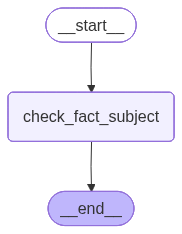

In [12]:
graph = StateGraph(AgentState)
graph.add_node("check_fact_subject", check_fact_subject)


# Entry point
graph.add_edge(START, "check_fact_subject")

fact_bot = graph.compile()

#visualization
try:
    from IPython.display import Image, display
    display(Image(fact_bot.get_graph().draw_mermaid_png()))
except Exception:
    pass


Run the agent in iterations, prompting the user everytime and log the conversation

In [13]:
def running_agent():
    conversation_history: List[BaseMessage] = []

    try:
        # Get initial claim and KEEP it in history before first invoke
        user_input = input("\nWhat claim do you want to investigate? ")
        conversation_history.append(HumanMessage(content=user_input))

        # Initial state
        state: AgentState = {
            "messages": conversation_history,
            "claim": user_input,
            "checkable": None,
            "subject": None,
            "quantitative": None,
            "based_on": None,
            "await_user": False,
            "confirmation": False,
            "question": None,
        }

        print(f"CLAIM: {state.get('claim')}")

        while True:


            # Sync messages with full history
            #state["messages"] = conversation_history

            # Run the graph
            result = fact_bot.invoke(state)

            # Update rolling conversation
            conversation_history = list(result["messages"])

            # Determine what to ask next (confirmation or clarification)
            question_text = result.get("question") or (
                "Could you clarify your claim a bit more?"
            )

            # Ask the question from the model/graph
            ai_question = AIMessage(content=question_text)
            conversation_history.append(ai_question)
            print("\n" + ai_question.content)

            # Get user's reply
            user_answer = input("> ")
            if user_answer.strip().lower() in ["exit", "quit"]:
                break
            else:
                conversation_history.append(HumanMessage(content=user_answer))

            # Keep claim FRESH so the next pass uses the *latest* user details
            state["messages"] = conversation_history
            state["claim"] = state.get("claim") + " " + user_answer

            # If we just asked for confirmation, drop the flag so next turn proceeds
            if result.get("confirmation"):
                state["confirmation"] = False

            # Clear question to avoid stale reuse
            state["question"] = None

        # Persist a readable log
        with open("logging.txt", "w", encoding="utf-8") as f:
            f.write("Your Conversation Log:\n")
            for m in conversation_history:
                if isinstance(m, HumanMessage):
                    f.write(f"You: {m.content}\n")
                elif isinstance(m, AIMessage):
                    f.write(f"AI: {m.content}\n\n")
            f.write("End of Conversation\n")

        print("Conversation saved to logging.txt")

    except KeyboardInterrupt:
        print("\nInterrupted by user. Goodbye!")

# run it
running_agent()


CLAIM: Youth unemployment rate in Croatia decreased by more than half due to government policies
Youth unemployment rate in Croatia decreased by more than half due to government policies

=== 1. CHECKABLE? ===
UNCHECKABLE
The claim lacks specific data (e.g., exact percentage, dates, sources) necessary to verify the assertion. The subject (Croatia's youth unemployment rate) is ambiguous without additional context.
subject: ''
question: 'Please provide the specific percentage decrease, dates, and sources to verify the claim.'

Please provide the specific percentage decrease, dates, and sources to verify the claim.
Youth unemployment rate in Croatia decreased by more than half due to government policies 2019 and 62%

=== 1. CHECKABLE? ===
CHECKABLE
The claim includes specific data (year 2019, 62% decrease) and a reason (government policies), making it verifiable.
subject: "Croatia's youth unemployment rate in 2019"
question: ''

To confirm: you’re making a *checkable* claim about **Croati